In [1]:
import torch
from tqdm import tqdm
import torch.nn.functional as F
import random
import matplotlib.pyplot as plt

%load_ext autoreload
%autoreload 2
import sys
sys.path.append('../')
from data.FloorPlanLoader import *
from model.VQAE import VQAE
from utils import *
from train import *

#Reproducability Checks:
random.seed(0) #Python
torch.manual_seed(0) #Torch
np.random.seed(0) #NumPy

### Hyperparameters

In [2]:
#Hyperparameter
batch_size = 128
n_hiddens = 32
n_residual_hiddens = 32
n_residual_layers = 1
embedding_dim = 64
n_embeddings = 218
beta = .25
lr = 3e-3
noise=False
noise_weight=0.05
img_channel=1

### Load Dataset

In [21]:
import pandas as pd
list(pd.read_excel('../data/res_index.xlsx').to_numpy().flatten())

[1,
 2,
 3,
 4,
 5,
 6,
 8,
 9,
 10,
 11,
 12,
 13,
 14,
 15,
 16,
 17,
 18,
 19,
 20,
 21,
 22,
 23,
 24,
 25,
 26,
 27,
 28,
 29,
 30,
 31,
 32,
 33,
 34,
 35,
 36,
 37,
 38,
 42,
 43,
 44,
 45,
 47,
 48,
 49,
 50,
 51,
 53,
 58,
 59,
 67,
 68,
 75,
 76,
 77,
 79,
 80,
 81,
 84,
 85,
 86,
 89,
 91,
 92,
 94,
 95,
 96,
 97,
 101,
 102,
 103,
 107,
 108,
 110,
 111,
 112,
 113,
 114,
 115,
 116,
 117,
 118,
 119,
 120,
 121,
 122,
 123,
 124,
 125,
 126,
 127,
 128,
 129,
 130,
 131,
 132,
 136,
 138,
 139,
 140,
 142,
 143,
 147,
 156,
 159,
 165,
 167,
 170,
 172,
 177,
 178,
 186,
 194,
 196,
 197,
 199,
 205,
 207,
 208,
 209,
 210,
 211,
 212,
 213,
 214,
 215,
 216,
 217,
 218,
 219,
 220,
 221,
 223,
 224,
 225,
 227,
 228,
 229,
 230,
 231,
 232,
 234,
 235,
 236,
 237,
 239,
 240,
 241,
 242,
 243,
 244,
 245,
 246,
 247,
 248,
 249,
 250,
 251,
 252,
 253,
 254,
 255,
 256,
 257,
 258,
 259,
 260,
 261,
 263,
 264,
 265,
 266,
 267,
 268,
 269,
 270,
 271,
 272,
 273,
 274,
 

In [30]:
#Load Dataset
floor = FloorPlanDataset(subset='../data/res_index.xlsx', multi_scale=False, preprocess=True)
# data_variance = floor.data_variance()

val_len = int(len(floor)/10)
train_set, val_set = torch.utils.data.random_split(floor, [len(floor)-val_len, val_len])
data_variance = get_data_variance(train_set)

print(f"data shape: {floor[0].shape}, dataset size: {len(floor)}, data variance: {data_variance}")

train_loader = torch.utils.data.DataLoader(train_set, batch_size = batch_size, shuffle = True)
validation_loader = torch.utils.data.DataLoader(val_set, batch_size = batch_size, shuffle = False)

data shape: torch.Size([1, 56, 56]), dataset size: 2138, data variance: 0.006867057178169489


### Load Best or Train

In [31]:
vqvae = VQAE(n_hiddens, n_residual_hiddens, n_residual_layers,
                n_embeddings, embedding_dim, 
                beta, img_channel).to(device)
optimizer = torch.optim.Adam(vqvae.parameters(), lr=lr, amsgrad=False)
train_res_recon_error = []
test_res_recon_error = []
start_epoch = 0
end_epoch = 150
best_loss = 2

##### load best checkpoint

In [43]:
vqvae.load_state_dict(torch.load("../checkpoint/vqae/best/95-vqae-0.21704871313912527.pt"))
# optimizer.load_state_dict(torch.load("checkpoint/95-adam-0.21704871313912527.pt"))

with open("../checkpoint/vqae/best/95-vqae_train-0.21704871313912527.json") as json_file:
    train_res_recon_error = json.load(json_file)
with open("../checkpoint/vqae/best/95-vqae_test-0.21704871313912527.json") as json_file:
    test_res_recon_error = json.load(json_file)
    
start_epoch = 96
end_epoch = 200
best_loss = 0.21704871313912527

##### train

In [44]:
for epoch in range(start_epoch, end_epoch+1):
    with tqdm(train_loader, unit="batch") as tepoch:
        vqvae.train()
        for data in tepoch:
            data_no_noise = data.to(device)
            optimizer.zero_grad()

            if noise:
                data = add_noise(data_no_noise, noise_weight=noise_weight)
            else:
                data = data_no_noise
            vq_loss, data_recon, perplexity = vqvae(data_no_noise)
            recon_error = F.mse_loss(data_recon, data_no_noise) / data_variance
            loss = recon_error + vq_loss
            loss.backward()

            optimizer.step()
            tepoch.set_postfix(loss=float(loss.detach().cpu()))
            train_res_recon_error.append(recon_error.item())

    avg_loss = 0
    vqvae.eval()
    with torch.no_grad():
        for data in validation_loader:
            data = data.to(device)

            vq_loss, data_recon, perplexity = vqvae(data)
            recon_error = F.mse_loss(data_recon, data) / data_variance
            loss = recon_error.item() * batch_size

            avg_loss += loss / val_len
            test_res_recon_error.append(loss)

    if epoch%5==0 and avg_loss<best_loss:
        best_loss = avg_loss
        best_epoch = epoch
        torch.save(vqvae.state_dict(), f"../checkpoint/{best_epoch}-vqae-{best_loss}.pt")
        torch.save(optimizer.state_dict(), f"../checkpoint/{best_epoch}-adam-{best_loss}.pt")
        with open(f"../checkpoint/{best_epoch}-vqae_train-{best_loss}.json", 'w', encoding ='utf8') as json_file:
            json.dump(train_res_recon_error, json_file, ensure_ascii = False)
        with open(f"../checkpoint/{best_epoch}-vqae_test-{best_loss}.json", 'w', encoding ='utf8') as json_file:
            json.dump(test_res_recon_error, json_file, ensure_ascii = False)

    print(f'Validation Loss: {avg_loss}')

100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.76batch/s, loss=0.176]


Validation Loss: 0.16665218693549644


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.52batch/s, loss=0.184]


Validation Loss: 0.18177567065601619


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.37batch/s, loss=0.158]


Validation Loss: 0.17419832077384556


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.38batch/s, loss=0.493]


Validation Loss: 0.21727684629914906


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.49batch/s, loss=0.222]


Validation Loss: 0.18857504616320975


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.52batch/s, loss=0.193]


Validation Loss: 0.17811808339866675


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.23batch/s, loss=0.201]


Validation Loss: 0.1798398819327914


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.42batch/s, loss=0.175]


Validation Loss: 0.1692453661994755


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.16batch/s, loss=0.216]


Validation Loss: 0.16933036410192928


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.48batch/s, loss=0.327]


Validation Loss: 0.17935853161162613


100%|███████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.03batch/s, loss=2]


Validation Loss: 0.24926046810239694


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.96batch/s, loss=0.274]


Validation Loss: 0.30589344579848887


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.27batch/s, loss=0.267]


Validation Loss: 0.20903345564721337


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.89batch/s, loss=0.156]


Validation Loss: 0.1877474090862722


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.49batch/s, loss=0.312]


Validation Loss: 0.177605454350861


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.52batch/s, loss=0.611]


Validation Loss: 0.22403505710368984


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.17batch/s, loss=0.193]


Validation Loss: 0.1881328994679339


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.45batch/s, loss=0.205]


Validation Loss: 0.1745271279778279


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.48batch/s, loss=0.197]


Validation Loss: 0.16956186070688453


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.57batch/s, loss=0.707]


Validation Loss: 0.18956695699915638


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.52batch/s, loss=0.192]


Validation Loss: 0.1964265975593961


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.37batch/s, loss=0.175]


Validation Loss: 0.16790450906529675


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.49batch/s, loss=0.165]


Validation Loss: 0.16780736860534956


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.19batch/s, loss=0.877]


Validation Loss: 0.19195843190654344


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.33batch/s, loss=0.758]


Validation Loss: 0.19452147864399943


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.69batch/s, loss=0.264]


Validation Loss: 0.17485619486777437


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.60batch/s, loss=0.154]


Validation Loss: 0.16166405834502456


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.74batch/s, loss=0.157]


Validation Loss: 0.16191526421918556


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.50batch/s, loss=0.177]


Validation Loss: 0.1613978085943231


100%|████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.87batch/s, loss=0.16]


Validation Loss: 0.15850847987501832


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.50batch/s, loss=0.148]


Validation Loss: 0.15597441946396806


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.53batch/s, loss=0.171]


Validation Loss: 0.16313174968594116


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.60batch/s, loss=0.162]


Validation Loss: 0.15930360247831388


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.54batch/s, loss=0.145]


Validation Loss: 0.15671554529610932


100%|████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.82batch/s, loss=0.24]


Validation Loss: 0.15904539403781087


100%|████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.46batch/s, loss=0.15]


Validation Loss: 0.15591906158017438


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.42batch/s, loss=0.201]


Validation Loss: 0.15556364551956103


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.55batch/s, loss=0.228]


Validation Loss: 0.1539100145510105


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.06batch/s, loss=0.194]


Validation Loss: 0.15743720363563216


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.40batch/s, loss=0.207]


Validation Loss: 0.15422191530326163


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.33batch/s, loss=0.162]


Validation Loss: 0.15458563683738172


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.48batch/s, loss=0.819]


Validation Loss: 0.16305353943730744


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.36batch/s, loss=0.209]


Validation Loss: 0.18101124472461394


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.65batch/s, loss=0.159]


Validation Loss: 0.15539980158559594


100%|████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.57batch/s, loss=0.15]


Validation Loss: 0.1600480057264158


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.45batch/s, loss=0.748]


Validation Loss: 0.1600308395887205


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.61batch/s, loss=0.605]


Validation Loss: 0.17890802123736887


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.40batch/s, loss=0.264]


Validation Loss: 0.15946344366655663


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.43batch/s, loss=0.136]


Validation Loss: 0.15874725664165656


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.34batch/s, loss=0.444]


Validation Loss: 0.1713389902607376


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.59batch/s, loss=0.215]


Validation Loss: 0.16443559709289265


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.45batch/s, loss=0.163]


Validation Loss: 0.1530932216017459


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.55batch/s, loss=0.301]


Validation Loss: 0.14892501562414034


100%|████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.69batch/s, loss=0.22]


Validation Loss: 1.0888926188151042


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.75batch/s, loss=0.165]


Validation Loss: 0.1515214678267358


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.67batch/s, loss=0.175]


Validation Loss: 0.14747959907066094


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.26batch/s, loss=0.207]


Validation Loss: 0.1493643326378764


100%|█████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.29batch/s, loss=0.2]


Validation Loss: 0.14741285530054513


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.58batch/s, loss=0.159]


Validation Loss: 0.1445171508430875


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.28batch/s, loss=0.171]


Validation Loss: 0.14814555924823025


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.20batch/s, loss=0.165]


Validation Loss: 0.14664838907304506


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.08batch/s, loss=0.222]


Validation Loss: 0.15128764300279213


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.23batch/s, loss=0.177]


Validation Loss: 0.1464951385354772


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.20batch/s, loss=0.274]


Validation Loss: 0.14476228096115756


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.67batch/s, loss=0.145]


Validation Loss: 0.14316536451169581


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.18batch/s, loss=0.149]


Validation Loss: 0.14726195536868675


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.24batch/s, loss=0.158]


Validation Loss: 0.14260566962157056


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.16batch/s, loss=0.137]


Validation Loss: 0.14263063529287706


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.36batch/s, loss=0.138]


Validation Loss: 0.14004307957322384


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.64batch/s, loss=0.125]


Validation Loss: 0.14403243355907744


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.23batch/s, loss=0.235]


Validation Loss: 0.148216059510137


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.16batch/s, loss=0.166]


Validation Loss: 0.14644226557771922


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.10batch/s, loss=0.175]


Validation Loss: 0.14136653774780844


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.04batch/s, loss=0.195]


Validation Loss: 0.13939955984482744


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.39batch/s, loss=0.218]


Validation Loss: 0.142874838600696


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.75batch/s, loss=0.232]


Validation Loss: 0.1404728329797306


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.51batch/s, loss=0.192]


Validation Loss: 0.13991501857417288


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.64batch/s, loss=0.208]


Validation Loss: 0.14417268188906388


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.45batch/s, loss=0.154]


Validation Loss: 0.13973079824671497


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.62batch/s, loss=0.166]


Validation Loss: 0.14015385802363006


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.02batch/s, loss=0.121]


Validation Loss: 0.13636782023828353


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.18batch/s, loss=0.239]


Validation Loss: 0.14240392496888066


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.41batch/s, loss=0.133]


Validation Loss: 0.1350177935031658


100%|████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.40batch/s, loss=0.14]


Validation Loss: 0.13535751199498422


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.54batch/s, loss=0.177]


Validation Loss: 0.13746778282201344


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.72batch/s, loss=0.728]


Validation Loss: 0.16946440683284275


100%|████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.05batch/s, loss=0.36]


Validation Loss: 0.16285170076038916


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.19batch/s, loss=0.172]


Validation Loss: 0.144917304527032


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.23batch/s, loss=0.165]


Validation Loss: 0.13822264066884216


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.28batch/s, loss=0.151]


Validation Loss: 0.13792900300361743


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.31batch/s, loss=0.606]


Validation Loss: 0.15551628864986797


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.90batch/s, loss=0.167]


Validation Loss: 0.1543814072586561


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.44batch/s, loss=0.281]


Validation Loss: 0.1460480533295394


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.51batch/s, loss=0.172]


Validation Loss: 0.13824384984835775


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.17batch/s, loss=0.155]


Validation Loss: 0.1354150503454074


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.13batch/s, loss=0.121]


Validation Loss: 0.12840545457293728


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.33batch/s, loss=0.417]


Validation Loss: 0.13908288176630584


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.44batch/s, loss=0.199]


Validation Loss: 0.13680209576244085


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.40batch/s, loss=0.124]


Validation Loss: 0.13665118239854984


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.30batch/s, loss=0.286]


Validation Loss: 0.13076516720050937


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00,  9.80batch/s, loss=0.138]


Validation Loss: 0.12989669674439047


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.29batch/s, loss=0.157]


Validation Loss: 0.13030803931151197


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 10.87batch/s, loss=0.204]


Validation Loss: 0.1302122689188926


100%|████████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.44batch/s, loss=0.14]


Validation Loss: 0.1277143182888837


100%|███████████████████████████████████████████████████████████████████| 16/16 [00:01<00:00, 11.41batch/s, loss=0.174]


Validation Loss: 0.12810542326018284


### Visualization

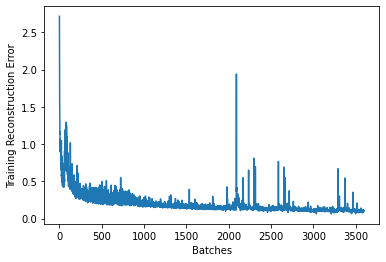

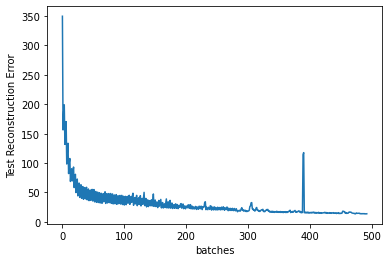

In [45]:
plt.plot(train_res_recon_error[5:])
plt.xlabel('Batches')
plt.ylabel('Training Reconstruction Error')
plt.show()

plt.plot(test_res_recon_error[5:])
plt.xlabel('batches')
plt.ylabel('Test Reconstruction Error')
plt.show()

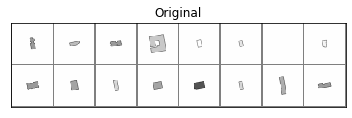

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


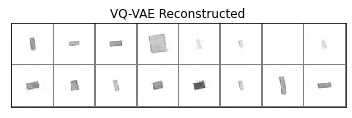

In [46]:
vqvae.eval()
temp_loader = torch.utils.data.DataLoader(val_set,batch_size=16,shuffle=True)
(valid_originals) = next(iter(temp_loader))
valid_originals = valid_originals.to(device)

_, valid_recon, _ = vqvae(valid_originals)
def show(img, title):
    npimg = img.numpy()
#     print(img)
    fig = plt.imshow(np.transpose(npimg, (1,2,0)), interpolation='nearest')
    fig.axes.get_xaxis().set_visible(False)
    fig.axes.get_yaxis().set_visible(False)
    fig.axes.set_title(title)


show(torchvision.utils.make_grid(valid_originals.cpu())+0.5, "Original")
plt.show()
show(torchvision.utils.make_grid(valid_recon.cpu().data) + 0.5, "VQ-VAE Reconstructed")
plt.show()